<a href="https://colab.research.google.com/github/ori112/monthly-beer-production/blob/main/monthly_beer_production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# monthly beer production time series
##exploring the data

In [80]:
# core libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.model_selection import TimeSeriesSplit ,cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# modeling and evaluating
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [81]:
# reading project file
df = pd.read_csv(r'/content/monthly-beer-production-in-austr.csv')

In [82]:
df.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [83]:
# inspecting info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    476 non-null    object 
 1   Monthly beer production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [84]:
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df.set_index('Month', inplace=True)
df.sort_index(inplace=True)

In [85]:
# inspecting info after conversion
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 476 entries, 1956-01-01 to 1995-08-01
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Monthly beer production  476 non-null    float64
dtypes: float64(1)
memory usage: 7.4 KB


In [86]:
df.describe()

,Monthly beer production
count,476.000000
mean,136.395378
std,33.738725
min,64.800000
25%,112.900000
50%,139.150000
75%,158.825000
max,217.800000


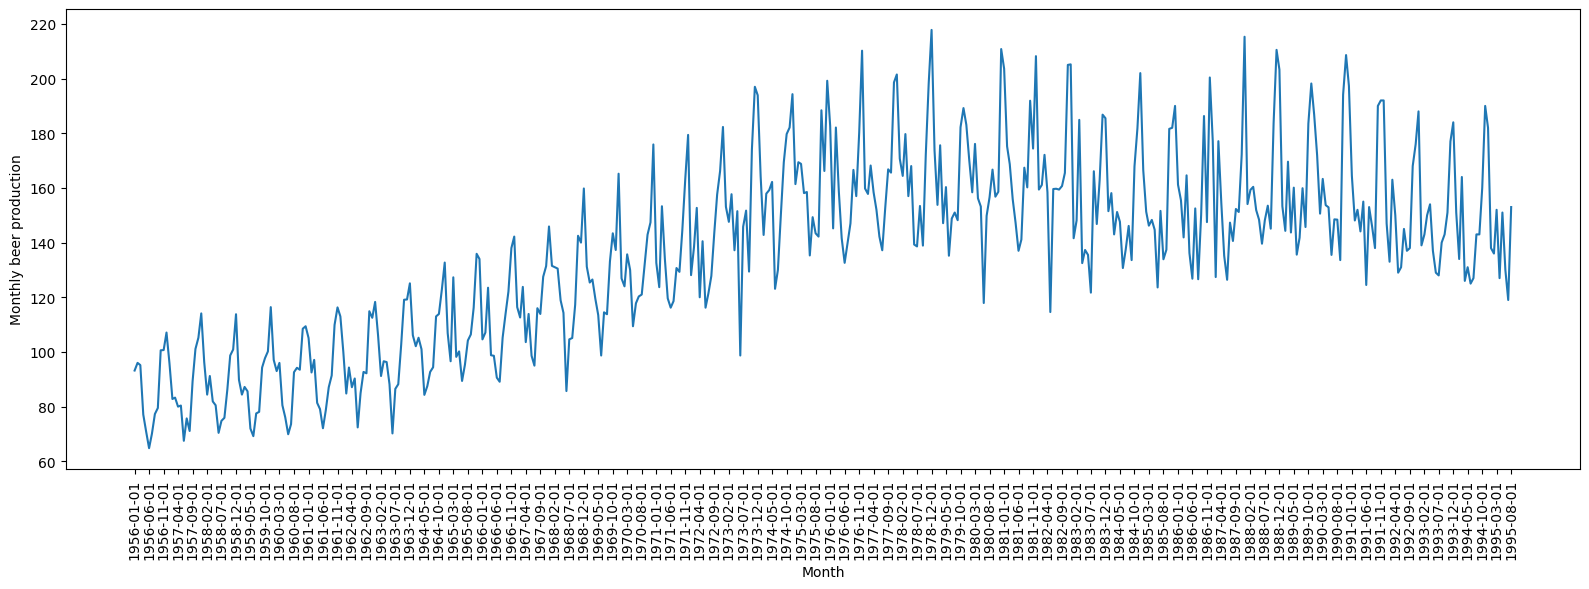

In [87]:
# visualizing the series
plt.figure(figsize=(16,6))
sns.lineplot(data=df, x="Month", y="Monthly beer production")
plt.xticks(ticks=df.index[::5], rotation=90)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

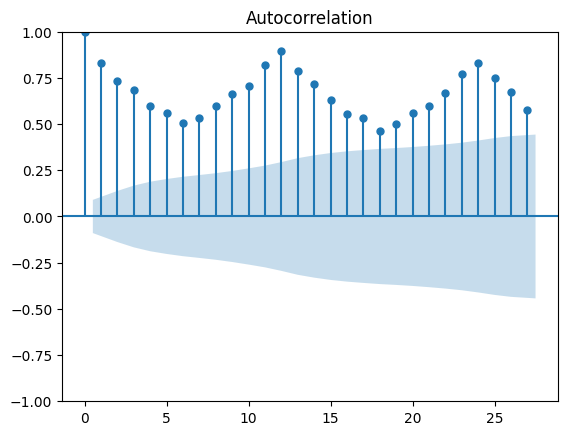

In [88]:
# inspecting ACF

plt.figure(figsize=(12,6))
plot_acf(df["Monthly beer production"])
plt.show()

<Figure size 1200x600 with 0 Axes>

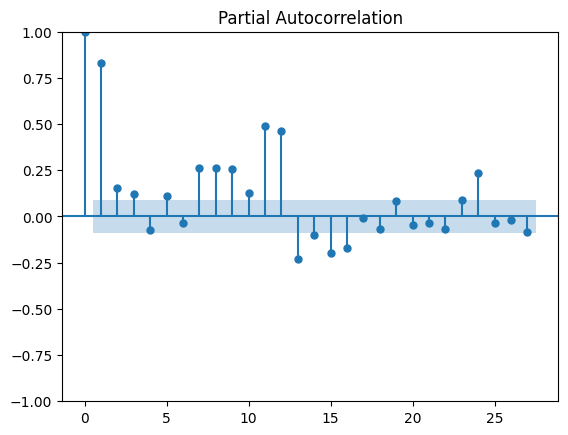

In [89]:
# inspecting PACF

plt.figure(figsize=(12,6))
plot_pacf(df["Monthly beer production"])
plt.show()

<Figure size 640x480 with 0 Axes>

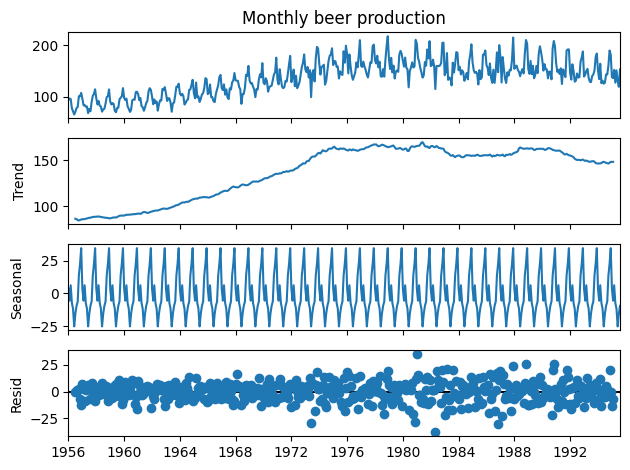

In [90]:
# decomposing the series

decompose = seasonal_decompose(df["Monthly beer production"], model='additive', period=12)

plt.figure()
decompose.plot()
plt.show()

In [91]:
# ADF test

result = adfuller(df["Monthly beer production"])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.282661418787577
p-value: 0.17762099829132505


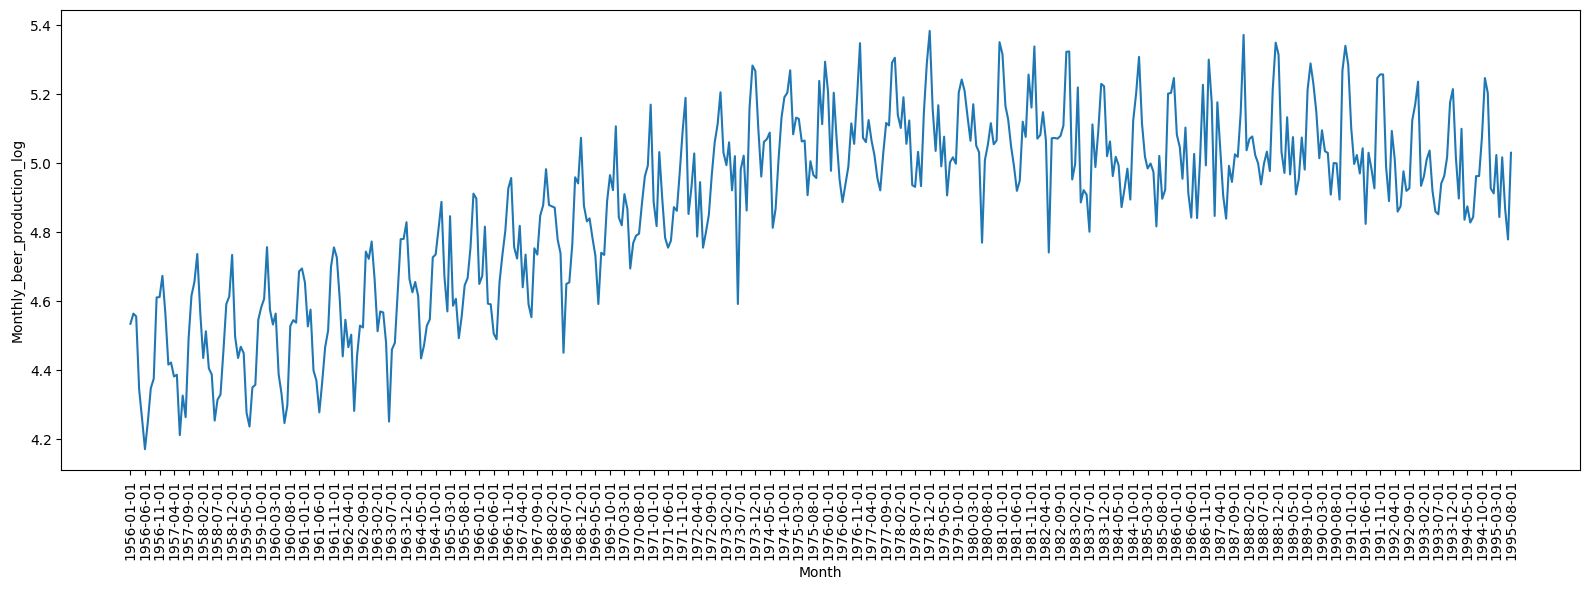

In [92]:
# transforming the series

df["Monthly_beer_production_log"] = np.log(df["Monthly beer production"])

# visualizing the series
plt.figure(figsize=(16,6))
sns.lineplot(data=df, x="Month", y="Monthly_beer_production_log")
plt.xticks(ticks=df.index[::5], rotation=90)
plt.tight_layout()
plt.show()

In [93]:
# ADF test

result = adfuller(df["Monthly_beer_production_log"])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.8007688010978495
p-value: 0.05816403419425954


In [96]:
diff_series = df["Monthly_beer_production_log"].diff().dropna()

In [97]:
result = adfuller(diff_series)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -4.86964567443618
p-value: 3.9942743177304e-05


## preprocessing and modeling the data

In [98]:
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]["Monthly_beer_production_log"]
test = df.iloc[train_size:]["Monthly_beer_production_log"]

In [99]:
model = SARIMAX(train,
                order=(1, 1, 1),
                seasonal_order=(0, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()
print(results.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:        Monthly_beer_production_log   No. Observations:                  380
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 432.015
Date:                            Sat, 14 Jun 2025   AIC                           -856.031
Time:                                    09:32:27   BIC                           -840.565
Sample:                                01-01-1956   HQIC                          -849.877
                                     - 08-01-1987                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1894      0.047     -4.035      0.000      -0.281      -0.097
ma.L1         -0.8796      0.027   

In [100]:
residuals = results.resid

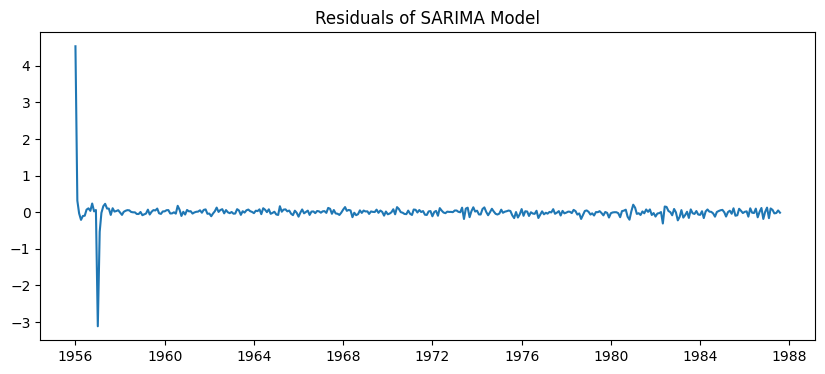

In [101]:
# Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals of SARIMA Model')
plt.show()

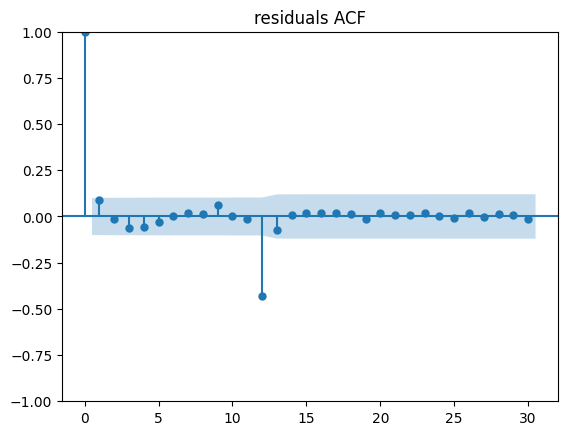

In [102]:
plot_acf(residuals, lags=30)
plt.title("residuals ACF")
plt.show()

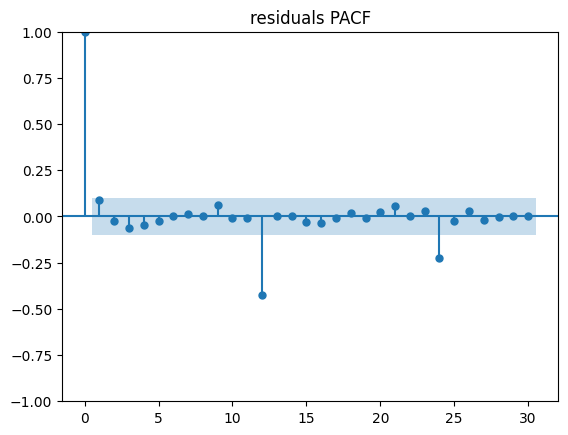

In [103]:
plot_pacf(residuals, lags=30)
plt.title("residuals PACF")
plt.show()

In [104]:
n_test = len(test)
preds = results.forecast(steps=n_test)

# --- Evaluate ---
rmse = np.sqrt(mean_squared_error(test, preds))
r2 = r2_score(test, preds)

print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

RMSE: 0.07808157257605168
R² Score: 0.6675538989353642


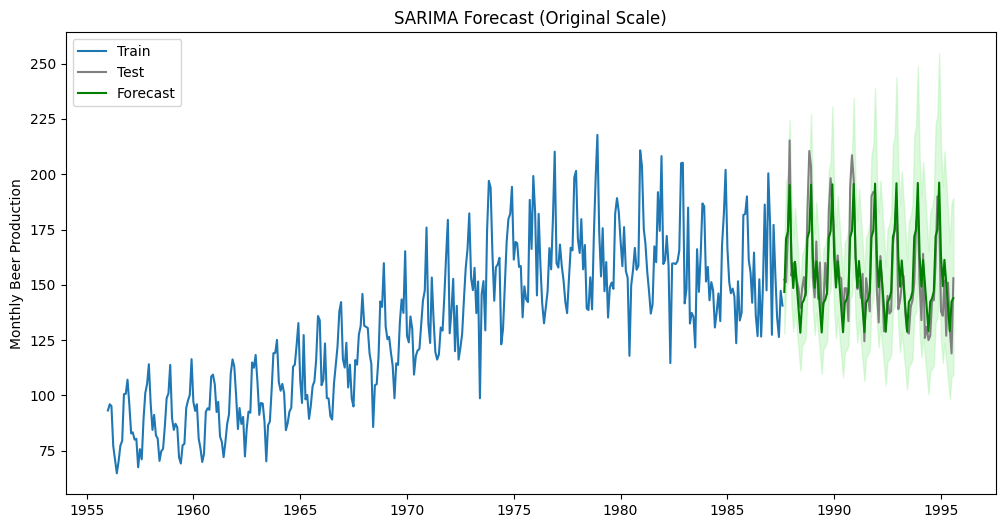

In [109]:
# Get log-level forecast and intervals
forecast = results.get_forecast(steps=len(test))
forecast_mean_log = forecast.predicted_mean
conf_int_log = forecast.conf_int()

# Inverting the log to get real units
forecast_mean   = np.exp(forecast_mean_log)
conf_int_lower  = np.exp(conf_int_log.iloc[:, 0])
conf_int_upper  = np.exp(conf_int_log.iloc[:, 1])

# Actual series in original scale for comparison
actual_test = df["Monthly beer production"].loc[test.index]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df["Monthly beer production"].loc[train.index], label='Train')
plt.plot(actual_test, label='Test', color='gray')
plt.plot(test.index, forecast_mean, label='Forecast', color='green')
plt.fill_between(test.index,
                 conf_int_lower, conf_int_upper,
                 color='lightgreen', alpha=0.3)
plt.title("SARIMA Forecast (Original Scale)")
plt.ylabel("Monthly Beer Production")
plt.legend()
plt.show()
